Combine relevant evaluation files into a single file

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
combined_eval_file = []

for mrt in MRT:

    results_dirs = [
        f'v3_MRT{mrt}_SimpleModels_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Kalman_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_every_day/00_summary_7stepsahead_interv',
        # f'hiera_MRT{mrt}_finetuned/00_summary_7stepsahead_ensemble',
        # f'hiera_MRT{mrt}_every_day/00_summary_7stepsahead_ensemble',
        f'v3_MRT{mrt}_Transformer_every_day/00_summary_7stepsahead_interv'
        ]

    eval_files = []
    for rd in results_dirs:
        eval_files.append(data_utils.join_ordinal_bptt_path('results', rd, 'evaluation.csv'))
        assert os.path.exists(eval_files[-1]), eval_files[-1]
    eval_reallabor_utils.clear_line_and_print(f'Combining evaluation files')
    mrt_combined_eval_file = eval_reallabor_utils.combine_evaluation_files(eval_files, save_path=None, specifier_name='latent_model')
    mrt_combined_eval_file['MRT'] = mrt

    use_days_from_file = data_utils.train_test_split_path(mrt, 'valid_first_alarms_no_con_smoothed.csv')
    valid_days = pd.read_csv(use_days_from_file, index_col=0)
    valid_days.columns = [int(c) for c in valid_days.columns]

    eval_reallabor_utils.clear_line_and_print(f'Filtering out invalid days')
    eval_only_valid_days = []
    for p, group in mrt_combined_eval_file.groupby('participant'):
        if p in valid_days.columns:
            eval_only_valid_days.append(group.loc[group['test_day'].isin(valid_days[p])])
    mrt_combined_eval_file = pd.concat(eval_only_valid_days, axis=0, ignore_index=True)

    mrt_combined_eval_file = eval_reallabor_utils.include_exclude_hypers(mrt_combined_eval_file, {'participant':[16,23,24,30,31,32,33,40,41,43,44,48,54,55,64,65,69,76,83,
                                                                                                                 202,204,205,208,214,218,219,221,225,227,239,241,246,247,248,249,272]}, {})
    
    mrt_combined_eval_file['prediction'] = mrt_combined_eval_file['prediction'].clip(0, 8)

    combined_eval_file.append(mrt_combined_eval_file)

eval_reallabor_utils.clear_line_and_print(f'Creating grand combined evaluation file')
combined_eval_file = pd.concat(combined_eval_file, axis=0, ignore_index=False)
if not os.path.exists(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv')):
    os.makedirs(data_utils.join_ordinal_bptt_path('results/_paper'), exist_ok=True)
    combined_eval_file.to_csv(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv'))

if 'train_until' in combined_eval_file.columns:
    combined_eval_file.loc[combined_eval_file['latent_model']=='hierarchized clipped-shallow-PLRNN', 'latent_model'] = 'hierarchized-clipped-shallow-PLRNN'
    combined_eval_file.loc[combined_eval_file['train_until'].isna(), 'train_until'] = combined_eval_file.loc[combined_eval_file['train_until'].isna(), 'train_on_data_until_timestep']

Creating grand combined evaluation file                                                                                                                                                                 

In [ ]:
diff_combined_eval_file = eval_reallabor_utils.create_difference_eval_df(combined_eval_file)
change_combined_eval_file = eval_reallabor_utils.create_difference_eval_df(combined_eval_file, only_changes=True)

Generate bootstrap samples for metrics CI calculation, calculate metrics and CIs

In [2]:
from eval_reallabor import reallabor_metrics
m_manager = reallabor_metrics.MetricsManager(combined_eval_file, ['MRT', 'latent_model'])

In [ ]:
m_manager.agg(m_manager.eval_df, func='count')

In [22]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # ci_manager_within_subj = reallabor_metrics.BootstrapConfidenceIntervals(combined_eval_file, ['MRT', 'latent_model'], bootstrap_samples, within_subjects=True, num_workers=32)
    # ci_manager_within_subj_change = reallabor_metrics.BootstrapConfidenceIntervals(change_combined_eval_file, ['MRT', 'latent_model'], bootstrap_samples, within_subjects=True, num_workers=32)
ci_manager_between_subj = reallabor_metrics.BootstrapConfidenceIntervals(combined_eval_file, ['MRT', 'latent_model'], 100, within_subjects=False, num_workers=32)

Generating bootstrap samples...: 100%|██████████| 100/100 [00:05<00:00, 19.04it/s]


In [43]:
metrics, errorbars = {}, {}
metrics['mae'], errorbars['mae'] = ci_manager_between_subj.get_metric_ci('mae', confidence=90, func='mean')
# metrics['diff_mae'], errorbars['diff_mae'] = ci_manager.diff_mae()
metrics['change mae'], errorbars['change mae'] = ci_manager_between_subj.get_metric_ci('change_mae', confidence=90, func='mean')
# metrics['r2'], errorbars['r2'] = ci_manager_within_subj.get_metric_ci('r2', confidence=50, relative_to={'latent_model': 'clipped-shallow-PLRNN'})
# metrics['change r2'], errorbars['change r2'] = ci_manager_within_subj_change.get_metric_ci('r2', confidence=50, relative_to={'latent_model': 'clipped-shallow-PLRNN'})
metrics['change sign correct'], errorbars['change sign correct'] = ci_manager_between_subj.get_metric_ci('change_sign_correct', confidence=90, func='mean')
metrics[r'$\Delta$ interv. mae'], errorbars[r'$\Delta$ interv. mae'] = ci_manager_between_subj.get_metric_ci('delta_interv_mae', confidence=90, func='mean')

In [ ]:
metrics, errorbars = {}, {}
# m_manager.raw_metrics.loc[(12, 2, 'KalmanFilter'), 'delta_interv_change_abs_residuals'] = np.nan
metrics['mae'] = m_manager.mae(func='mean')
errorbars['mae'] = m_manager.mae(func='sem')
metrics['change mae'] = m_manager.change_mae(func='mean')
errorbars['change mae'] = m_manager.change_mae(func='sem')
metrics['change sign correct'] = m_manager.change_sign_correct(func='mean')
errorbars['change sign correct'] = m_manager.change_sign_correct(func='sem')
metrics[r'$\Delta$ interv. mae'] = m_manager.delta_interv_change_mae(func='mean')
errorbars[r'$\Delta$ interv. mae'] = m_manager.delta_interv_change_mae(func='sem')

Plot metrics

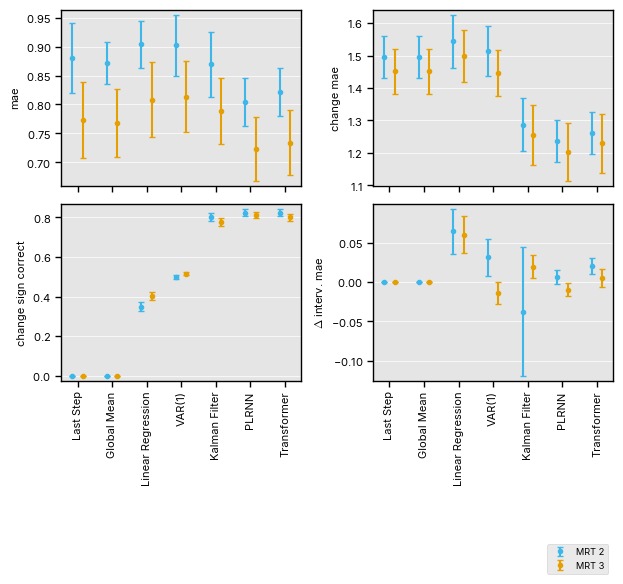

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
from plotting_utils import adjust_ylim

model_labels = {
                    'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    # 'hierarchized-clipped-shallow-PLRNN': 'H-PLRNN',
                    'Transformer': 'Transformer'
                    }

with PaperStyle():

    color_cycle = ["#3DB7E9", "#e69f00"]
    offset = [-0.15, 0.15]

    ''' COMBINE BOTH MRTS INTO ONE PLOT '''
    fig, axes = plt.subplots(2, len(metrics)//2, figsize=(6.27, 5), sharex=True)
    axes = axes.flatten()
    for i, m in enumerate(metrics):
        for k, mrt in enumerate(MRT):
            this_line = metrics[m].loc[mrt].loc[model_labels.keys()]
            this_errorbars = errorbars[m].loc[mrt].loc[model_labels.keys()].T
            axes[i].errorbar(np.arange(len(model_labels))+offset[k], this_line, yerr=this_errorbars, linestyle='', marker='.', label=f'MRT {mrt}')
        ylim = axes[i].get_ylim()
        # for k, mrt in enumerate(MRT):
        #     for l, model in enumerate(model_labels.keys()):
        #         if sig[m].loc[(mrt, model), 'clipped-shallow-PLRNN']:
        #             axes[i].text(l+offset[k], ylim[1], '*', fontsize=12, color=color_cycle[k], ha='center', va='bottom')
        axes[i].set(ylabel=m, xticks=range(len(model_labels)))
        axes[i].set_xticklabels(model_labels.values(), rotation=90)
        adjust_ylim(axes[i], 0.03, 0.03)
    plt.tight_layout()
    axes[-1].legend(bbox_to_anchor=(1, -0.9))
    # plt.savefig('../results/_paper/model_comparison_every_day_ensemble.svg', dpi=300)

    plt.show()



Display metrics as table

In [ ]:
model_labels = {
                    'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    # 'hierarchized-clipped-shallow-PLRNN': 'H-PLRNN',
                    'Transformer': 'Transformer'
                    }
pd.DataFrame(metrics).loc[pd.IndexSlice[[2,3], model_labels.keys()], :].round(3)

In [ ]:
pd.DataFrame(errorbars).loc[pd.IndexSlice[[2,3], model_labels.keys()], :].round(4)

In [ ]:
test_results = m_manager.wilcoxon('abs_residuals', separately_for_each=['MRT'])
test_results['pvalue'] *= test_results.index.get_level_values('latent_model').unique().size - 1
test_results

In [ ]:
from collections import defaultdict

model_labels = {
                    'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'hierarchized-clipped-shallow-PLRNN': 'H-PLRNN',
                    'Transformer': 'Transformer'
                    }
rel_r2 = {}
r2_errorbars = {}
bootstrap_samples = 100
for name, efile in zip(('absolute', 'changes'),
                           (combined_eval_file, change_combined_eval_file)):
    rel_r2[name] = []
    r2_errorbars[name] = []
    for ml in model_labels:
        print(f'Calculating relative r2 PLRNN-{ml} for {name} values')
        rel_r2[name].append(eval_reallabor_utils.pseudo_r2_piepho(efile.loc[efile['latent_model']=='clipped-shallow-PLRNN'], ['MRT'],
                                                            compare_to_eval_df=efile.loc[efile['latent_model']==ml]))
        r2_errorbars[name].append(eval_reallabor_utils.bootstrap(eval_reallabor_utils.pseudo_r2_piepho, 
                                                        efile.loc[efile['latent_model']=='clipped-shallow-PLRNN'], 
                                                        ['MRT'],
                                                        compare_to_eval_df=efile.loc[efile['latent_model']==ml],
                                                        samples=bootstrap_samples, relative_values=True, use_tqdm=True,
                                                        interval=50))
        
    rel_r2[name] = pd.concat(rel_r2[name], axis=0, keys=model_labels.keys(), names=['latent_model']).swaplevel(0,1)
    r2_errorbars[name] = pd.concat(r2_errorbars[name], axis=0, keys=model_labels.keys(), names=['latent_model']).swaplevel(0,1)    

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
from plotting_utils import adjust_ylim

model_labels = {
                    'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'hierarchized-clipped-shallow-PLRNN': 'H-PLRNN',
                    'Transformer': 'Transformer'
                }

with PaperStyle():

    fig, axes = plt.subplots(2, len(rel_r2), figsize=(6.27, 6))
    offset = [-0.15, 0.15]

    for i, m in enumerate(metrics):
        for k, mrt in enumerate(MRT):
            this_line = metrics[m].loc[mrt].loc[model_labels.keys()]
            this_errorbars = errorbars[m].loc[mrt].loc[model_labels.keys()].T
            axes[0, i].errorbar(np.arange(len(model_labels))+offset[k], this_line, yerr=this_errorbars, linestyle='', marker='.', label=f'MRT {mrt}')
        ylim = axes[0, i].get_ylim()
        axes[0, i].set(xticks=range(len(model_labels)))
        axes[0, i].set_xticklabels(model_labels.values(), rotation=90)
        adjust_ylim(axes[0, i], 0.03, 0.03)

    model_labels.pop('clipped-shallow-PLRNN')
    for i, m in enumerate(rel_r2):
        for k, mrt in enumerate(MRT):
            this_line = rel_r2[m].loc[mrt].loc[model_labels.keys()]
            this_errorbars = r2_errorbars[m].loc[mrt].loc[model_labels.keys()].T
            axes[1, i].errorbar(np.arange(len(model_labels))+offset[k], this_line, yerr=this_errorbars, linestyle='', marker='.', label=f'MRT {mrt}')
            
        axes[1, i].set(xticks=range(len(model_labels)))
        axes[1, i].set_xticklabels(model_labels.values(), rotation=90)
        adjust_ylim(axes[1, i], 0.03, 0.03)
    
    axes[0, 0].set(ylabel='MAE')
    axes[1, 0].set(ylabel='Additional $r^2$ of PLRNN')
    axes[0, 0].set(title='absolute scores')
    axes[0, 1].set(title='change scores')
    plt.tight_layout()
    axes[1, -1].legend(bbox_to_anchor=(1, -1))
    plt.savefig('../results/_paper/model_comparison_mae_and_rel_r2_every_day_ensemble.png', dpi=300)
    plt.show()

Number of samples involved in the calculations

In [ ]:
characteristics = []
for eval_file in [combined_eval_file, diff_combined_eval_file, change_combined_eval_file]:

    samples = {
        'subjects': eval_file.groupby(['MRT'])['participant'].nunique(),
        'days_total': eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').sum(),
        'days_median': eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').median(),
        'days_q25': eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').quantile(0.25),
        'days_q75': eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').quantile(0.75),
        'samples_total': eval_file.groupby(['MRT', 'participant', 'test_day', 'steps'])['ground_truth'].mean().unstack('MRT').count()
    }

    characteristics.append(pd.DataFrame(samples))
characteristics = pd.concat(characteristics, axis=0, keys=['mae', 'diff_mae', 'change_mae'], names=['metric'])
characteristics

Comparison of Training Time and Number of Parameters

In [ ]:
training_time = eval_reallabor_utils.training_time(combined_eval_file, ['MRT', 'latent_model'])
training_time_errorbars = eval_reallabor_utils.bootstrap(eval_reallabor_utils.training_time, combined_eval_file, ['MRT', 'latent_model'], samples=10, relative_values=True, use_tqdm=True)
number_of_params = combined_eval_file.groupby('latent_model')['n_params'].mean()
number_of_params['InputsRegression'] = 8*15 + 15
number_of_params['KalmanFilter'] = 7*7 + 8*7 + 15*7
number_of_params['VAR1'] = 15*15 + 15*8 + 15
number_of_params['hierarchized-clipped-shallow-PLRNN'] /= 52
for mrt in MRT:
    training_time.loc[(mrt, 'hierarchized-clipped-shallow-PLRNN')] /= 52

Compute ratio of successful runs

In [ ]:
total_values = combined_eval_file.loc[combined_eval_file['latent_model']=='MeanPredictor'].groupby('MRT')['ground_truth'].count()
success_ratio = combined_eval_file.loc[combined_eval_file['ground_truth'].notna()].groupby(['MRT', 'latent_model'])['prediction'].count() / total_values

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
from plotting_utils import bars, adjust_ylim

model_labels = {
                    'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'hierarchized-clipped-shallow-PLRNN': 'H-PLRNN',
                    'Transformer': 'Transformer'
                    }

with PaperStyle():

    fig, axes = plt.subplots(1, 2, figsize=(6.27, 3))

    bars(training_time.unstack('MRT').loc[model_labels.keys()].T.to_numpy(), ax=axes[0], 
         yerr=training_time_errorbars.unstack('MRT').loc[model_labels.keys()].T.to_numpy().reshape(2, 2, -1))      
    axes[0].set(ylabel='training time (seconds)', xticks=range(len(model_labels)))
    axes[0].set_xticklabels(model_labels.values(), rotation=90)
    axes[0].legend(labels=['MRT 2', 'MRT 3'])
    adjust_ylim(axes[0], 0.03, 0)
    
    axes[1].bar(range(len(model_labels)), number_of_params.loc[model_labels.keys()])            
    axes[1].set(ylabel='# parameters', xticks=range(len(model_labels)))
    axes[1].set_xticklabels(model_labels.values(), rotation=90)
    adjust_ylim(axes[1], 0.03, 0)

#     bars(success_ratio.unstack('MRT').loc[model_labels.keys()].T.to_numpy(), ax=axes[2])
#     axes[2].set(ylabel='convergence ratio', xticks=range(len(model_labels)))
#     axes[2].set_xticklabels(model_labels.values(), rotation=90)
#     axes[2].set_ylim(0.5, 1)
#     axes[2].legend(labels=['MRT 2', 'MRT 3'])
#     adjust_ylim(axes[2], 0.03, 0)

    plt.tight_layout()
    plt.savefig('../results/_paper/training_time_number_of_params_best_runs.png', dpi=300)
    plt.show()    

In [ ]:
print(training_time.unstack('MRT'))

In [ ]:
print(number_of_params)

In [ ]:
print(success_ratio.unstack('MRT'))